In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from helper import plot_anomalies
from Dataset import DatasetLoader
from pyanomaly.stats import MAD, Tukey
from pyanomaly.timeseries import moving_average, moving_average_score, \
                                    twitter, twitter_score

In [2]:
loader = DatasetLoader()
#loader.print_all()

In [3]:
ds_names = loader.get_list('realKnownCause')
ds_names

['ambient_temperature_system_failure.csv',
 'cpu_utilization_asg_misconfiguration.csv',
 'ec2_request_latency_system_failure.csv',
 'machine_temperature_system_failure.csv',
 'nyc_taxi.csv',
 'rogue_agent_key_hold.csv',
 'rogue_agent_key_updown.csv']

## Preprocessamento

In [4]:
df_raw, labels = loader.load('cpu_utilization_asg_misconfiguration.csv')
df_raw.head()

,value
timestamp,
2014-05-14 01:14:00,85.835
2014-05-14 01:19:00,88.167
2014-05-14 01:24:00,44.595
2014-05-14 01:29:00,56.282
2014-05-14 01:34:00,36.534


Valores **duplicados** e **missing data**

In [40]:
df_raw.index.duplicated().sum()

0

In [5]:
df_raw.index.min(), df_raw.index.max(), df_raw.shape

(Timestamp('2014-05-14 01:14:00'),
 Timestamp('2014-07-15 17:19:00'),
 (18050, 1))

In [6]:
pd.date_range(start=df_raw.index.min(), end=df_raw.index.max(), freq='5T')

DatetimeIndex(['2014-05-14 01:14:00', '2014-05-14 01:19:00',
               '2014-05-14 01:24:00', '2014-05-14 01:29:00',
               '2014-05-14 01:34:00', '2014-05-14 01:39:00',
               '2014-05-14 01:44:00', '2014-05-14 01:49:00',
               '2014-05-14 01:54:00', '2014-05-14 01:59:00',
               ...
               '2014-07-15 16:34:00', '2014-07-15 16:39:00',
               '2014-07-15 16:44:00', '2014-07-15 16:49:00',
               '2014-07-15 16:54:00', '2014-07-15 16:59:00',
               '2014-07-15 17:04:00', '2014-07-15 17:09:00',
               '2014-07-15 17:14:00', '2014-07-15 17:19:00'],
              dtype='datetime64[ns]', length=18050, freq='5T')

**Visualização**

Text(0.5, 1.0, 'Série original')

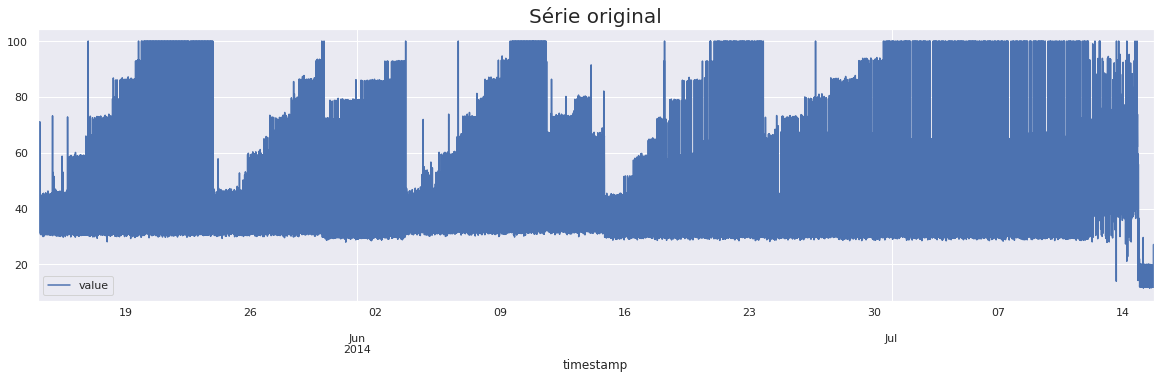

In [7]:
df_raw.plot(figsize=(20, 5));
plt.title('Série original', fontsize=20)

Text(0.5, 1.0, 'Rolling window - mean')

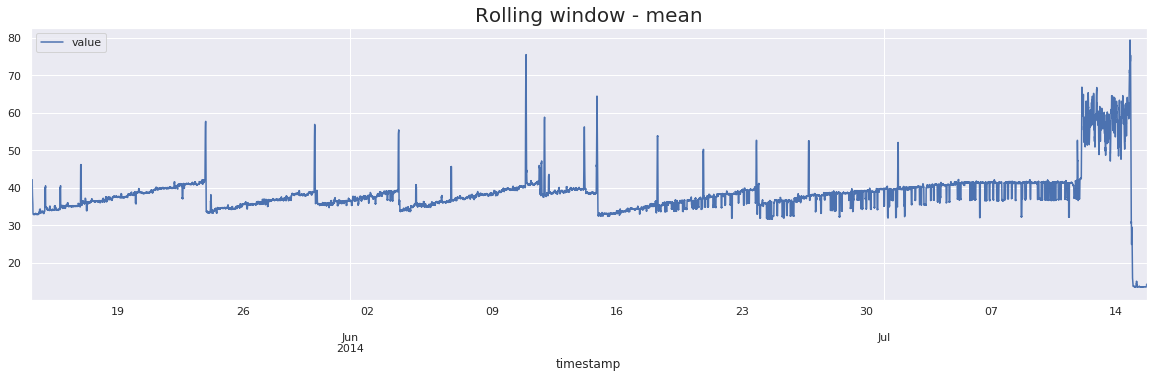

In [8]:
df_mean = df_raw.rolling(12).mean().dropna()

df_mean.plot(figsize=(20, 5));
plt.title('Rolling window - mean', fontsize=20)

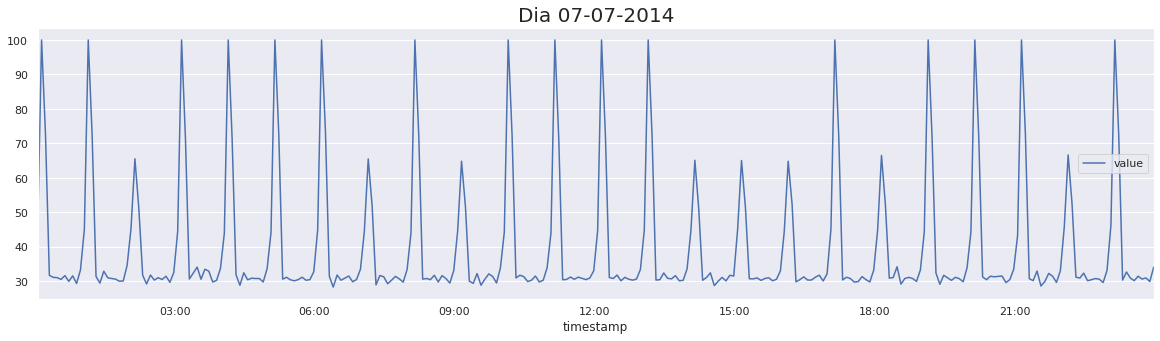

In [9]:
df_raw['2014-07-07'].plot(figsize=(20, 5))
plt.title('Dia 07-07-2014', fontsize=20);

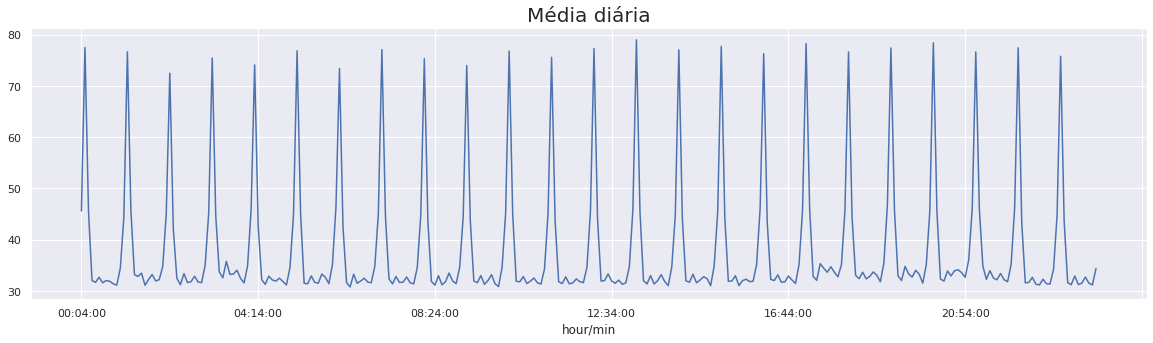

In [10]:
# calculando o valor medio em cada intervalo de tempo
df_raw['hour/min'] = df_raw.index.strftime('%H:%M:%S')
hour_mean = df_raw.groupby('hour/min')['value'].mean()

hour_mean.plot(figsize=(20, 5))
plt.title('Média diária', fontsize=20);

## Algoritmos

### MAD

In [11]:
df = df_raw['value']

In [13]:
mad = MAD()
mad.fit(df)
madpredict = mad.predict(df)
madpredict.head()

timestamp
2014-05-14 01:14:00    85.835
2014-05-14 01:19:00    88.167
2014-05-14 01:24:00    44.595
2014-05-14 01:29:00    56.282
2014-05-14 02:04:00    49.724
Name: value, dtype: float64

In [14]:
# score por dia
mad_dayscore = madpredict.resample('D').count().dropna()/288

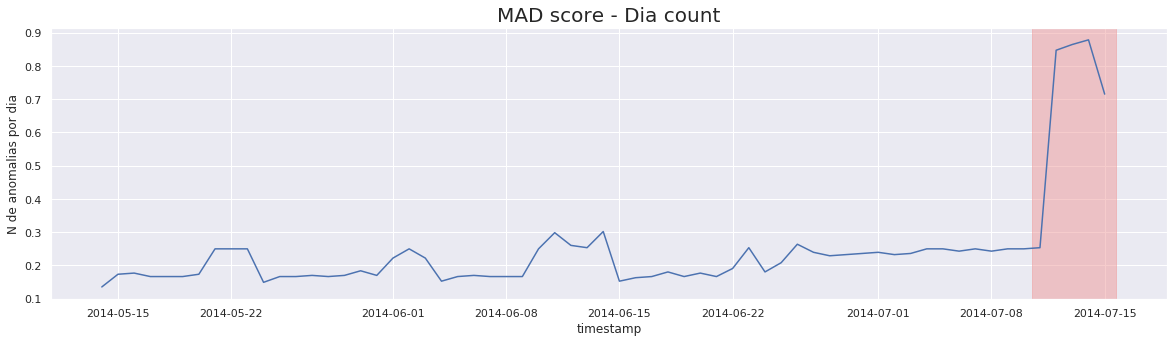

In [15]:
plot_anomalies(mad_dayscore, windows=labels)

plt.title("MAD score - Dia count",fontsize=20)
plt.ylabel('N de anomalias por dia');

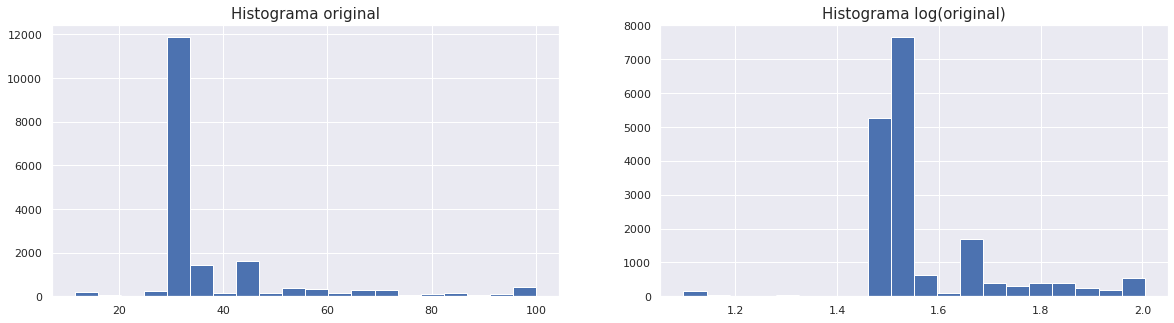

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

df.hist(ax=ax[0], bins=20)
np.log10(df + 1).hist(ax=ax[1], bins=20);
ax[0].set_title('Histograma original', fontsize=15)
ax[1].set_title('Histograma log(original)', fontsize=15);

In [20]:
df_log = np.log10(df + 1)

madlog = MAD()
madlog.fit(df_log)
madlogpredict = madlog.predict(df_log)
madlogpredict.head()

timestamp
2014-05-14 01:14:00    1.938695
2014-05-14 01:19:00    1.950204
2014-05-14 01:24:00    1.658917
2014-05-14 01:29:00    1.758018
2014-05-14 02:04:00    1.705213
Name: value, dtype: float64

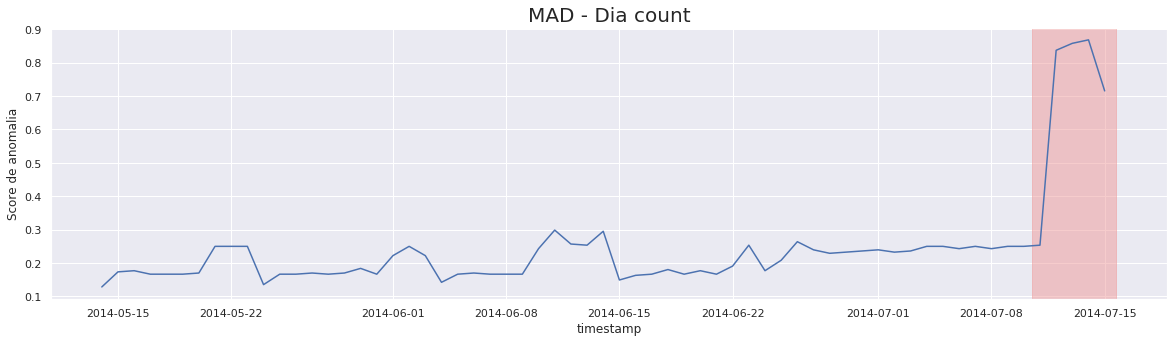

In [21]:
#score por dia
madlog_dayscore = madlogpredict.resample('D').count().dropna()/288

plot_anomalies(madlog_dayscore, windows=labels)

plt.title("MAD - Dia count",fontsize=20)
plt.ylabel('Score de anomalia');

### Tukey

In [23]:
df = df_raw['value']

In [24]:
tu = Tukey()
tu.fit(df)
tupredict = tu.predict(df)
tupredict.head()

timestamp
2014-05-14 01:14:00    85.835
2014-05-14 01:19:00    88.167
2014-05-14 01:24:00    44.595
2014-05-14 01:29:00    56.282
2014-05-14 02:04:00    49.724
Name: value, dtype: float64

In [25]:
tu_dayscore = tupredict.resample('D').count().dropna()/288

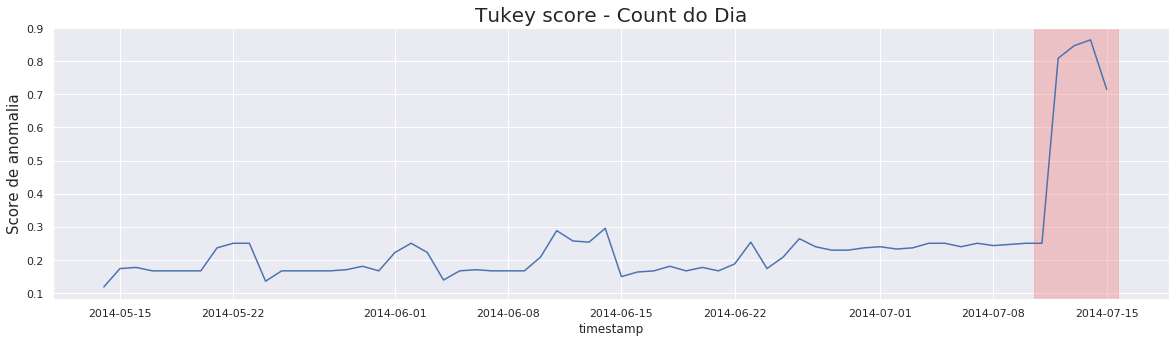

In [29]:
plot_anomalies(tu_dayscore, windows=labels)
plt.title("Tukey score - Count do Dia",fontsize=20)
plt.ylabel('Score de anomalia', fontsize=15);

### Twitter

In [30]:
df = df_raw['value']

In [31]:
twitterpredict = twitter(df, period=12)
twitterpredict

timestamp
2014-05-14 01:14:00    85.835
2014-05-14 01:19:00    88.167
2014-05-14 01:24:00    44.595
2014-05-14 01:29:00    56.282
2014-05-14 03:29:00    50.673
                        ...  
2014-07-15 16:59:00    13.498
2014-07-15 17:04:00    19.831
2014-07-15 17:09:00    27.165
2014-07-15 17:14:00    12.873
2014-07-15 17:19:00    12.129
Name: value, Length: 1736, dtype: float64

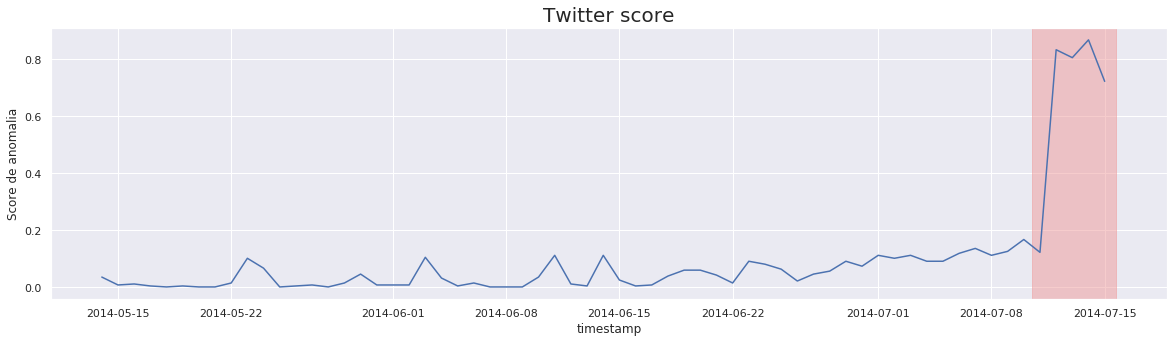

In [32]:
twitter_dayscore = twitterpredict.resample('D').count().dropna()/288

plot_anomalies(twitter_dayscore, windows=labels)
plt.title("Twitter score",fontsize=20)
plt.ylabel('Score de anomalia');

## Forecast

### ARIMA

In [33]:
#TODO

### Holt-Winters

In [34]:
#TODO

## Comparação por rank

In [35]:
from helper import top_k_precision, plot_precision_recall_curve

### Resample

In [36]:
# Calculando top k precision para cada tecnica
mad_topk = top_k_precision(mad_dayscore, labels, k=5)
tu_topk = top_k_precision(tu_dayscore, labels, k=5)
twitter_topk = top_k_precision(twitter_dayscore, labels, k=5)

df_topk = pd.DataFrame({'mad': mad_topk,
                        'tukey': tu_topk,
                        'twitter': twitter_topk},
                        index=np.arange(1, 6))
df_topk

,mad,tukey,twitter
1,1.000000,1.000000,1.000000
2,0.500000,0.500000,0.500000
3,0.333333,0.333333,0.333333
4,0.250000,0.250000,0.250000
5,0.200000,0.200000,0.200000


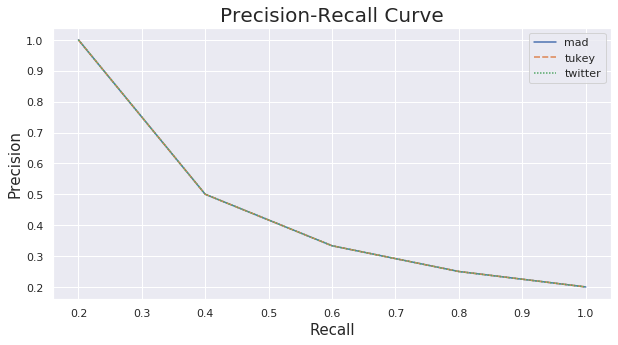

In [37]:
fig, ax = plot_precision_recall_curve(df_topk)

### Save

In [38]:
df_topk.index.names = ['rank']
df_topk.to_csv('./results/' + 'topk_score_' + ds_names[1])

In [39]:
fig.savefig('./results/' + 'topk_score_' + ds_names[1].split('.')[0] + '.jpg')